In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [# M-ACT V1 model regression
                  (True, "run_20171001_18_13_25_meta_actV1_40ep_tau0.001_lr4e05"),
                  (True, "run_20171001_18_27_50_meta_actV1_40ep_tau0.003_lr4e05"),
                  (True, "run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05"),
                  (True, "run_20171001_18_06_58_meta_actV1_40ep_tau0.005_lr4e05"),
                  ]



In [3]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

path_ext = None
experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        if path_ext is not None:
            exp_file_path = os.path.join(path_ext, exp_path[1])
        else:
            exp_file_path = exp_path[1]
            
        exp = Experiment.load(exp_file_path, do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class
        new_experiments[-1].training_horizon = experiments[-1].config.T
        new_experiments[-1].avg_num_opt_steps = experiments[-1].avg_num_opt_steps

INFO - created local logger for experiment with model meta_actV1_regression_tau0.001
INFO - INFO - loaded existing model from file logs/run_20171001_18_13_25_meta_actV1_40ep_tau0.001_lr4e05/meta_actV1_regression_tau0.001.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight']
INFO - created local logger for experiment with model meta_actV1_regression_tau0.003
INFO - INFO - loaded existing model from file logs/run_20171001_18_27_50_meta_actV1_40ep_tau0.003_lr4e05/meta_actV1_regression_tau0.003.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lst

0 Loading model meta_actV1_regression_tau0.001 (q-prob 0.90) / run_20171001_18_13_25_meta_actV1_40ep_tau0.001_lr4e05
1 Loading model meta_actV1_regression_tau0.003 (q-prob 0.90) / run_20171001_18_27_50_meta_actV1_40ep_tau0.003_lr4e05
2 Loading model meta_actV1_regression_tau0.004 (q-prob 0.90) / run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05
3 Loading model meta_actV1_regression_tau0.005 (q-prob 0.90) / run_20171001_18_06_58_meta_actV1_40ep_tau0.005_lr4e05


In [63]:
# del new_experiments
new_experiments = []
unrolled_steps=100
num_of_funcs = 10000

if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_stats_" + str(num_of_funcs) + "_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20171001_18_13_25_meta_actV1_40ep_tau0.001_lr4e05 / path run_20171001_18_13_25_meta_actV1_40ep_tau0.001_lr4e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20171001_18_27_50_meta_actV1_40ep_tau0.003_lr4e05 / path run_20171001_18_27_50_meta_actV1_40ep_tau0.003_lr4e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05 / path run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/exp_eval_stats_10000_100steps.dll
Loading experiment run_20171001_18_06_58_meta_actV1_40ep_tau0.005_lr4e05 / path run_20171001_18_06_58_meta_actV1_40ep_tau0.005_lr4e05/exp_eval_stats_10000_100steps.dll
Ready


In [4]:
with open("data/test_regression_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


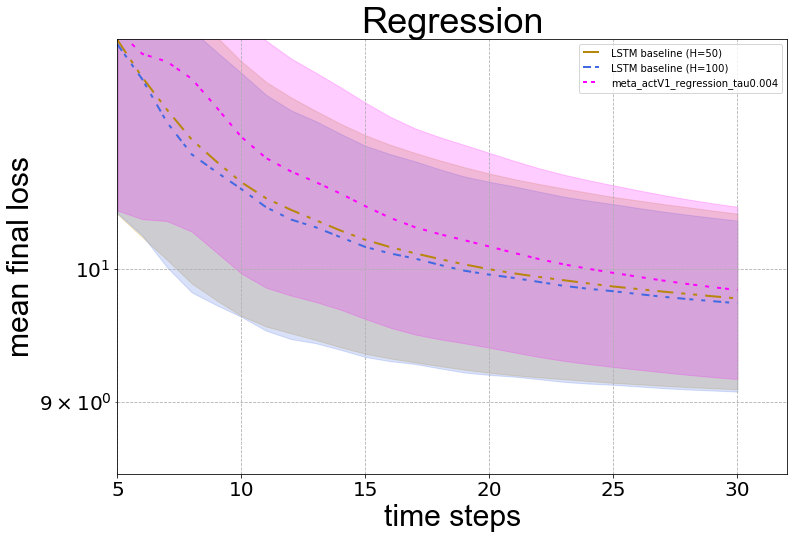

In [39]:
#new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[2], new_experiments[4],
#                 new_experiments[6]] 
#, new_experiments[4]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10reg_MACT_all_H_30_100", 
                                              loss_type="loss",
                                              min_step=5,
                                              max_step=30,
                                              sort_exper="Regression",
                                              log_scale=True,
                                              # y_lim=[8, 60],
                                              y_lim=[8.5, 12],
                                              with_stddev=True,
                                              runID=None)

In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [8]:
exp_idx = 3
model = models[exp_idx]

max_steps = 100
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model meta_actV1_regression_tau0.005 with q-prob 0.900


INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 64.415  17.495  15.909  14.275  12.982  12.416  12.067  11.906  11.674
  11.521  11.296  11.179  11.017  10.946  10.816  10.763  10.664  10.631
  10.551  10.527  10.46   10.446  10.389  10.38   10.33   10.327  10.282
  10.282  10.242  10.244  10.208  10.212  10.178  10.184  10.153  10.16
  10.13   10.139  10.11   10.12   10.093  10.103  10.077  10.087  10.062
  10.074  10.049  10.061  10.037  10.049  10.026  10.038  10.016  10.028
  10.006  10.019   9.997  10.01    9.989  10.002   9.981   9.994   9.973
   9.987   9.966   9.98    9.96    9.974   9.953   9.967   9.947   9.962
   9.942   9.956   9.936   9.951   9.931   9.946   9.926   9.941   9.921
   9.936   9.917   9.931   9.912   9.927   9.908   9.923   9.904   9.919
   9.9     9.915   9.896   9.911   9.893   9.908   9.889   9.904   9.886
   9.901   9.882]
INFO - ! - Validation last step 5 - !
INFO - Epoch: 400 - evaluation - halting step distribution
INFO - [   0  293 4

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [ ]:

exp_idx = 3
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


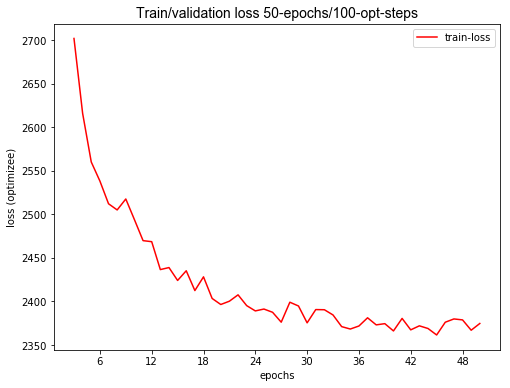

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


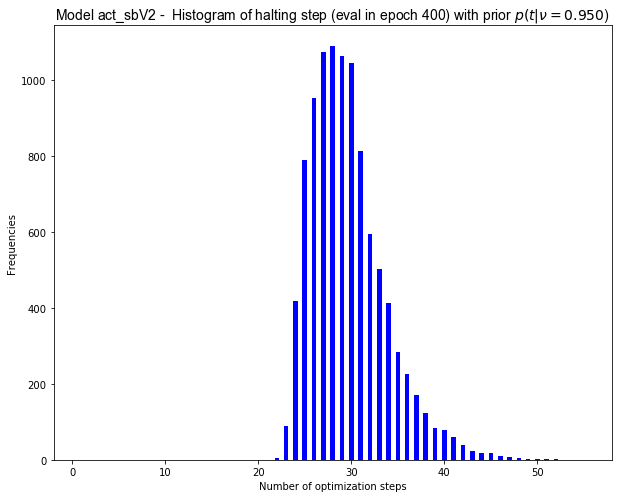

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

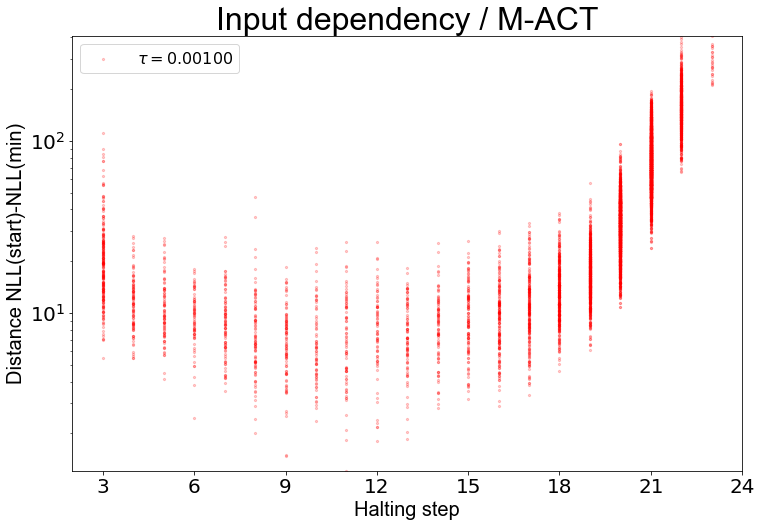

In [72]:
plot_loss_versus_halting_step(new_experiments[0], epoch=400, do_show=True, do_save=False,
                             p_title="Input dependency / M-ACT", huge=True, log_scale=True)

INFO - Successfully saved fig logs/run_20170930_18_49_40_metaV1_60ep_50ops_lr1e05/10dregT_50ops_10bptt_20ep_10steps.png


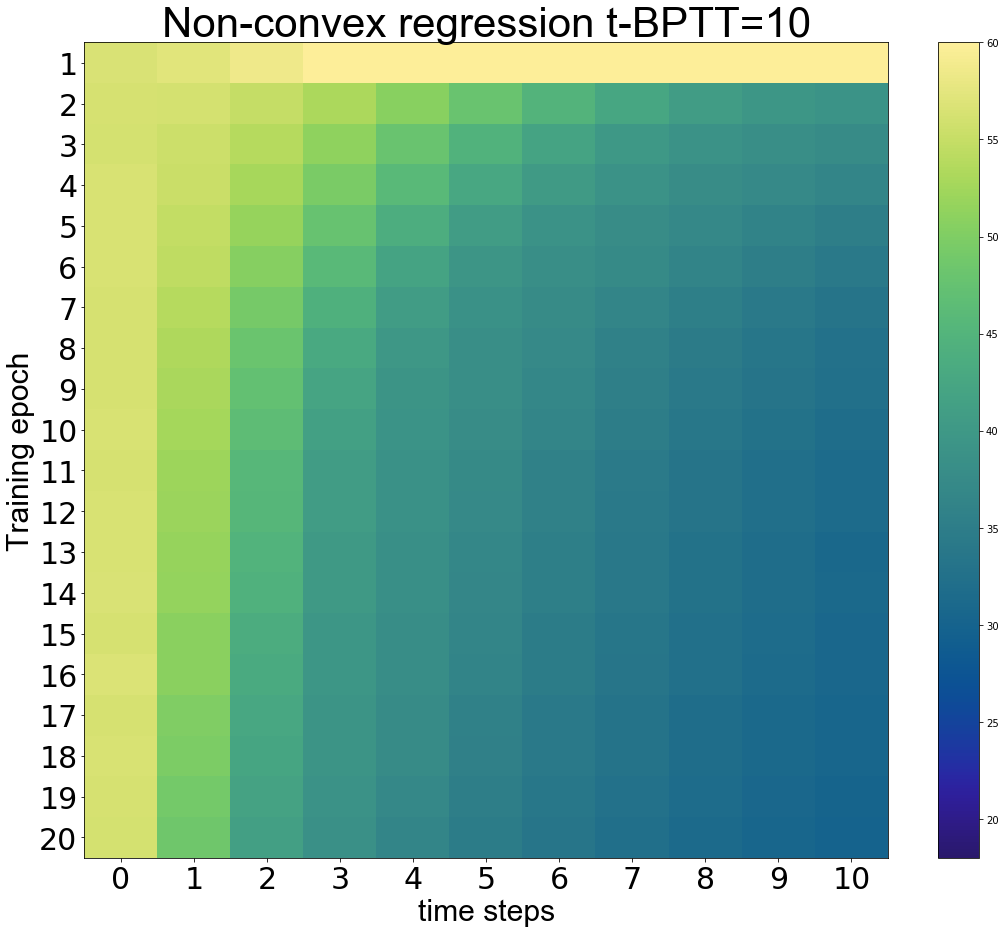

In [15]:
plot_image_map_losses(experiments[3], fig_name="10dregT_50ops_10bptt_20ep_10steps", do_save=True, do_show=True, 
                      max_epoch=20, max_time_step=11, fig_title="Non-convex regression t-BPTT=10", 
                      scale= [18,60], huge=True)

In [32]:
expers_to_load = [# M-ACT V1 model regression
                  (True, "run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05"),
                  (True, "run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05"),
                  (True, "run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05"),
                  (False, "run_20171001_18_06_58_meta_actV1_40ep_tau0.005_lr4e05"),
                  ]

In [3]:
test_funcs = RegressionFunction(n_funcs=10000, n_samples=10, stddev=1., x_dim=10, use_cuda=True, 
                                calc_true_params=False)
with open("data/test_regression_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [20]:
experiments[2].generate_figures()

INFO - Successfully saved fig logs/run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/loss_train_meta_actV1_40ep_tau0.004.png
(100, 40)
INFO - Successfully saved fig logs/run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/loss_optimizer_train_meta_actV1_40ep_tau0.004.png
INFO - Successfully saved fig logs/run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/loss_eval_meta_actV1_40ep_tau0.004.png
(100, 40)
INFO - Successfully saved fig logs/run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/loss_optimizer_eval_meta_actV1_40ep_tau0.004.png
INFO - Successfully saved fig logs/run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/train_step_loss_map_meta_actV1_40ep_tau0.004.png
INFO - Successfully saved fig logs/run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/gradient_statistics.png
INFO - Successfully saved fig logs/run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05/